# 1. Loading Data

In [2]:
import sys
import gc
import os
import warnings
import pickle
import statsmodels.api as sm
from pylab import rcParams
import time
from  datetime import datetime, timedelta

import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing, metrics

warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)

register_matplotlib_converters()
sns.set()

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

# # Google Colab trick to extend memory
# a = []
# while(1):
#     a.append('1')


## 1.1 Functions

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


def display_missing(df):    
    for col in df.columns.tolist():  
        if df[col].isnull().sum() != 0:
            print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')
    


## 1.2 Loading data 


In [4]:
# Mount google drive
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

In [5]:
# Setting directories where data is stored and ouptut dir
if IN_COLAB:
    DATA_GRID_INPUT_DIR = './drive/My Drive/Colab Notebooks' 
    DATA_OUTPUT_DIR = './drive/My Drive/Colab Notebooks'
    !ls './drive/My Drive/Colab Notebooks'
else:
    DATA_GRID_INPUT_DIR = '.'
    DATA_OUTPUT_DIR = '.'

In [30]:
print('Loading the data...')

train = pd.read_pickle(f'{DATA_GRID_INPUT_DIR}/train_direct_model.pkl')
val = pd.read_pickle(f'{DATA_GRID_INPUT_DIR}/val_direct_model.pkl')
test = pd.read_pickle(f'{DATA_GRID_INPUT_DIR}/test_direct_model.pkl')

Loading the data...


## 1.3 Init variables

In [31]:
h = 28 # Prediction horizon
MAX_LAGS = 150 # Max lags used
SEED = 7


In [32]:
LAST_TRAIN_DAY_DT = datetime(2016, 3, 20) # Sunday
LAST_TRAIN_VAL__DAY_DT = datetime(2016, 3, 27) # Sunday
FIRST_PRED_DAY_DT = datetime(2016, 4, 25) # Monday
TEST_SET_DAY = FIRST_PRED_DAY_DT - timedelta(days=1)
TRAINING_DAYS_NUM = 7 # Days for training

# 2. Fit& Predict

In [33]:
cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id']
useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday", "weights"] + \
                ['wday', 'month', 'year', 'snap_CA', 'snap_TX', 'snap_WI']  # may be is better to add snaps 
targets = ['y_' + str(i) for i in range(1, h + 1)]

train_cols = train.columns[~train.columns.isin(useless_cols + targets)]

In [34]:
MAX_ROUNDS = 5000

params = {
    'num_leaves': 80,
    'objective': 'regression',
    'min_data_in_leaf': 200,
    'learning_rate': 0.02,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'metric': 'l2',
    'num_threads': 4,
    'seed': SEED
}


# Recursive model's params
# params = {
#             'boosting_type': 'gbdt',
#             'objective': 'tweedie',
#             'tweedie_variance_power': 1.1,
#             'metric': 'rmse',
#             'subsample': 0.5,
#             'subsample_freq': 1,
#             'learning_rate': 0.03,
#             'num_leaves': 2**11-1,
#             'min_data_in_leaf': 2**12-1,
#             'feature_fraction': 0.5,
#             'max_bin': 100,
#             'n_estimators': 1400,
#             'boost_from_average': False,
#             'verbose': 1,
#             'n_jobs': 4, # For local computation optimization
#             'seed': SEED,
# } 


In [65]:
%%time

# Setting train, val and test sets
# Converting to numpy for optimal memory usage
X_train_np = train[train_cols].values.astype(np.float16)
X_val_np = val[train_cols].values.astype(np.float16)
X_test_np = test[train_cols].values.astype(np.float16)

# Initializing dataframe for later submission
final_preds = pd.DataFrame(test['id'])

# Training a models separate for each day
for day in range(1, h + 1):
#for day in range(1, 2):
    # Updating y's for every iteration
    y_train_np = train['y_' + str(day)].values.astype(np.float16)
    y_val_np = val['y_' + str(day)].values.astype(np.float16)
    
    train_data = lgb.Dataset(X_train_np, label = y_train_np, feature_name = list(train_cols), categorical_feature=cat_feats, free_raw_data=False)
    val_data = lgb.Dataset(X_val_np, label = y_val_np, feature_name = list(train_cols), categorical_feature=cat_feats, free_raw_data=False)
    
    print(f"Training day {day}:")
    
    m_lgb = lgb.train(params, train_data, valid_sets = [train_data, val_data], 
                  verbose_eval=50, early_stopping_rounds=125, num_boost_round=MAX_ROUNDS)
    
    
    feature_importance = pd.DataFrame({"Value": m_lgb.feature_importance("gain"), "Feature": m_lgb.feature_name()}) \
                    .sort_values(by="Value", ascending=False)
    
    # Printing 50 most important features
    print(feature_importance.iloc[0:50])
    
    final_preds[f'F{day}'] = m_lgb.predict(X_test_np)
    
        # May be we will need it to intermediate check of performance
#     val_preds.append(m_lgb.predict(
#         X_valid_np, num_iteration=m_lgb.best_iteration or MAX_ROUNDS))
    

final_preds.to_pickle(f'{DATA_GRID_INPUT_DIR}/final_preds.pkl', protocol=3)

Training day 1:
Training until validation scores don't improve for 125 rounds
[50]	training's l2: 4.90167	valid_1's l2: 3.51626
[100]	training's l2: 3.78609	valid_1's l2: 3.12216
[150]	training's l2: 3.47371	valid_1's l2: 3.17519
[200]	training's l2: 3.3266	valid_1's l2: 3.24501
Early stopping, best iteration is:
[96]	training's l2: 3.82746	valid_1's l2: 3.12153
            Value                  Feature
55   8.307763e+06            mean_14_decay
48   4.761898e+06             mean_7_decay
62   4.580171e+06            mean_30_decay
53   3.991107e+06                  mean_14
46   3.741787e+06                   mean_7
0    6.017809e+05                  item_id
70   5.337630e+05                median_60
104  3.400778e+05             mean_4_dow_2
37   3.345035e+05                  lag_t27
107  3.322624e+05            mean_20_dow_3
10   2.031885e+05                   lag_t0
111  1.861147e+05            mean_20_dow_5
43   1.393082e+05                    min_3
56   1.367027e+05                

Training until validation scores don't improve for 125 rounds
[50]	training's l2: 5.5049	valid_1's l2: 6.05204
[100]	training's l2: 4.23568	valid_1's l2: 4.82905
[150]	training's l2: 3.86551	valid_1's l2: 4.57847
[200]	training's l2: 3.68037	valid_1's l2: 4.49993
[250]	training's l2: 3.55072	valid_1's l2: 4.47172
[300]	training's l2: 3.44043	valid_1's l2: 4.45259
[350]	training's l2: 3.34388	valid_1's l2: 4.43473
[400]	training's l2: 3.25488	valid_1's l2: 4.42699
[450]	training's l2: 3.17498	valid_1's l2: 4.42192
[500]	training's l2: 3.09841	valid_1's l2: 4.4167
[550]	training's l2: 3.02724	valid_1's l2: 4.41007
[600]	training's l2: 2.96231	valid_1's l2: 4.40525
[650]	training's l2: 2.89823	valid_1's l2: 4.40445
[700]	training's l2: 2.83853	valid_1's l2: 4.4004
[750]	training's l2: 2.784	valid_1's l2: 4.3967
[800]	training's l2: 2.7339	valid_1's l2: 4.39488
[850]	training's l2: 2.68214	valid_1's l2: 4.38836
[900]	training's l2: 2.63466	valid_1's l2: 4.39082
[950]	training's l2: 2.58926

[350]	training's l2: 3.36375	valid_1's l2: 4.10943
[400]	training's l2: 3.28639	valid_1's l2: 4.10759
Early stopping, best iteration is:
[299]	training's l2: 3.44705	valid_1's l2: 4.10323
            Value                  Feature
62   1.360100e+07            mean_30_decay
46   2.769584e+06                   mean_7
55   2.098886e+06            mean_14_decay
60   2.046946e+06                  mean_30
0    1.717485e+06                  item_id
69   7.545562e+05            mean_60_decay
107  6.278662e+05            mean_20_dow_3
63   5.616009e+05                median_30
72   5.236976e+05                   max_60
76   5.182306e+05           mean_140_decay
48   5.175201e+05             mean_7_decay
70   5.052133e+05                median_60
53   4.998725e+05                  mean_14
106  4.991409e+05             mean_4_dow_3
41   2.977700e+05             mean_3_decay
34   2.611714e+05                  lag_t24
30   2.049261e+05                  lag_t20
109  2.008932e+05            mean_20_d

[700]	training's l2: 2.44022	valid_1's l2: 4.10145
[750]	training's l2: 2.39404	valid_1's l2: 4.10045
Early stopping, best iteration is:
[648]	training's l2: 2.48862	valid_1's l2: 4.09779
            Value         Feature
62   1.221122e+07   mean_30_decay
0    2.487508e+06         item_id
55   2.178608e+06   mean_14_decay
53   1.867635e+06         mean_14
77   1.266858e+06      median_140
63   9.540562e+05       median_30
60   7.825173e+05         mean_30
69   6.370483e+05   mean_60_decay
46   5.107122e+05          mean_7
114  4.788529e+05    mean_4_dow_7
50   3.746783e+05           min_7
72   3.130193e+05          max_60
115  2.827901e+05   mean_20_dow_7
56   2.809540e+05       median_14
26   2.725568e+05         lag_t16
2    2.392016e+05        store_id
33   2.130620e+05         lag_t23
42   1.868558e+05        median_3
107  1.761225e+05   mean_20_dow_3
105  1.623204e+05   mean_20_dow_2
80   1.618259e+05         std_140
16   1.593678e+05          lag_t6
19   1.483980e+05          lag

Early stopping, best iteration is:
[515]	training's l2: 4.54373	valid_1's l2: 5.94087
            Value                  Feature
62   2.392813e+07            mean_30_decay
55   5.493501e+06            mean_14_decay
0    4.714736e+06                  item_id
104  2.463369e+06             mean_4_dow_2
60   2.416466e+06                  mean_30
77   2.106048e+06               median_140
105  1.486795e+06            mean_20_dow_2
76   1.132573e+06           mean_140_decay
69   1.067972e+06            mean_60_decay
48   1.018976e+06             mean_7_decay
102  8.522336e+05             mean_4_dow_1
65   8.014924e+05                   max_30
70   6.392702e+05                median_60
31   6.313956e+05                  lag_t21
79   5.938394e+05                  max_140
38   5.641197e+05                  lag_t28
25   4.773318e+05                  lag_t15
2    3.605691e+05                 store_id
80   3.576131e+05                  std_140
46   3.487278e+05                   mean_7
53   3.4554

Training day 17:
Training until validation scores don't improve for 125 rounds
[50]	training's l2: 4.51104	valid_1's l2: 3.91307
[100]	training's l2: 3.62049	valid_1's l2: 3.28605
[150]	training's l2: 3.34635	valid_1's l2: 3.18202
[200]	training's l2: 3.21141	valid_1's l2: 3.16385
[250]	training's l2: 3.11043	valid_1's l2: 3.15513
[300]	training's l2: 3.02446	valid_1's l2: 3.14222
[350]	training's l2: 2.94179	valid_1's l2: 3.14537
[400]	training's l2: 2.87049	valid_1's l2: 3.1427
[450]	training's l2: 2.80548	valid_1's l2: 3.14475
Early stopping, best iteration is:
[326]	training's l2: 2.98225	valid_1's l2: 3.14054
            Value                  Feature
62   1.190257e+07            mean_30_decay
53   2.054069e+06                  mean_14
0    2.018818e+06                  item_id
69   1.698047e+06            mean_60_decay
70   1.036212e+06                median_60
109  8.188628e+05            mean_20_dow_4
76   6.667471e+05           mean_140_decay
55   5.684318e+05            mean_

Training day 20:
Training until validation scores don't improve for 125 rounds
[50]	training's l2: 8.41391	valid_1's l2: 6.70352
[100]	training's l2: 6.41409	valid_1's l2: 5.33252
[150]	training's l2: 5.78651	valid_1's l2: 5.08935
[200]	training's l2: 5.49083	valid_1's l2: 5.01961
[250]	training's l2: 5.28561	valid_1's l2: 4.96551
[300]	training's l2: 5.12029	valid_1's l2: 4.94432
[350]	training's l2: 4.97717	valid_1's l2: 4.917
[400]	training's l2: 4.83965	valid_1's l2: 4.89235
[450]	training's l2: 4.71656	valid_1's l2: 4.87546
[500]	training's l2: 4.60019	valid_1's l2: 4.85076
[550]	training's l2: 4.49544	valid_1's l2: 4.84046
[600]	training's l2: 4.39773	valid_1's l2: 4.83381
[650]	training's l2: 4.29936	valid_1's l2: 4.8293
[700]	training's l2: 4.21144	valid_1's l2: 4.83683
[750]	training's l2: 4.12354	valid_1's l2: 4.8313
Early stopping, best iteration is:
[670]	training's l2: 4.26208	valid_1's l2: 4.8272
            Value                  Feature
62   2.467082e+07            mean

Training day 23:
Training until validation scores don't improve for 125 rounds
[50]	training's l2: 5.05003	valid_1's l2: 4.4841
[100]	training's l2: 4.07226	valid_1's l2: 3.67855
[150]	training's l2: 3.77077	valid_1's l2: 3.54912
[200]	training's l2: 3.61849	valid_1's l2: 3.52744
[250]	training's l2: 3.50569	valid_1's l2: 3.52139
[300]	training's l2: 3.41149	valid_1's l2: 3.51949
[350]	training's l2: 3.32178	valid_1's l2: 3.5245
[400]	training's l2: 3.24173	valid_1's l2: 3.53287
Early stopping, best iteration is:
[280]	training's l2: 3.44712	valid_1's l2: 3.51529
            Value                  Feature
62   9.523693e+06            mean_30_decay
69   3.193179e+06            mean_60_decay
53   3.091964e+06                  mean_14
0    2.168056e+06                  item_id
109  1.452554e+06            mean_20_dow_4
76   1.387336e+06           mean_140_decay
60   7.607945e+05                  mean_30
55   7.517995e+05            mean_14_decay
72   4.532418e+05                   max_60


Training day 26:
Training until validation scores don't improve for 125 rounds
[50]	training's l2: 5.92097	valid_1's l2: 4.76777
[100]	training's l2: 4.58256	valid_1's l2: 3.91141
[150]	training's l2: 4.167	valid_1's l2: 3.80162
[200]	training's l2: 3.96328	valid_1's l2: 3.77499
[250]	training's l2: 3.8177	valid_1's l2: 3.759
[300]	training's l2: 3.69788	valid_1's l2: 3.74675
[350]	training's l2: 3.59395	valid_1's l2: 3.73053
[400]	training's l2: 3.4955	valid_1's l2: 3.71964
[450]	training's l2: 3.40696	valid_1's l2: 3.71323
[500]	training's l2: 3.32393	valid_1's l2: 3.70668
[550]	training's l2: 3.24544	valid_1's l2: 3.70879
[600]	training's l2: 3.17685	valid_1's l2: 3.70626
[650]	training's l2: 3.11034	valid_1's l2: 3.70478
[700]	training's l2: 3.04662	valid_1's l2: 3.71013
[750]	training's l2: 2.98728	valid_1's l2: 3.71636
Early stopping, best iteration is:
[631]	training's l2: 3.1353	valid_1's l2: 3.70158
            Value                  Feature
62   1.332092e+07            mean_3

CPU times: user 33min 38s, sys: 10.3 s, total: 33min 48s
Wall time: 8min 54s


In [63]:
print(y_train_np.shape)
X_train_np.shape

(213414,)


,id,F1
0,HOBBIES_1_001_CA_1_validation,0.997945
1,HOBBIES_1_002_CA_1_validation,0.350100
2,HOBBIES_1_003_CA_1_validation,0.702991
3,HOBBIES_1_004_CA_1_validation,1.576614
4,HOBBIES_1_005_CA_1_validation,1.177397
...,...,...
30485,FOODS_3_823_WI_3_validation,0.499049
30486,FOODS_3_824_WI_3_validation,0.367153
30487,FOODS_3_825_WI_3_validation,0.946953
30488,FOODS_3_826_WI_3_validation,1.020195


In [66]:
# Just to be sure that we doing all right, loading sample submission file
sample_submission = pd.read_csv(f'{DATA_GRID_INPUT_DIR}/sample_submission.csv')
sample_submission = pd.DataFrame(sample_submission['id'])

# Again to be sure everything is fine, we create evaluation items
final_preds_eval = final_preds.copy()
for i in range(1, h + 1):
    final_preds_eval[f'F{i}'] = 0
final_preds_eval['id'] = final_preds_eval['id'].str.replace('validation', 'evaluation')

# Merge final_preds
final_preds = pd.concat([final_preds, final_preds_eval], axis=0)

final_submission = sample_submission.merge(final_preds, on=['id'], copy=False)

final_submission.to_csv(f"{DATA_OUTPUT_DIR}/submission_direct.csv",index=False)

In [29]:
%%time

m_lgb = lgb.train(params, train_data, valid_sets = [train_data, valid_data], 
                  verbose_eval=50)


[50]	training's rmse: 2.58384	valid_1's rmse: 2.10438
[100]	training's rmse: 2.30596	valid_1's rmse: 1.90933
[150]	training's rmse: 2.26382	valid_1's rmse: 1.88935
[200]	training's rmse: 2.23834	valid_1's rmse: 1.88045
[250]	training's rmse: 2.21861	valid_1's rmse: 1.87299
[300]	training's rmse: 2.20569	valid_1's rmse: 1.8671
[350]	training's rmse: 2.19573	valid_1's rmse: 1.86278
[400]	training's rmse: 2.18751	valid_1's rmse: 1.85894
[450]	training's rmse: 2.18052	valid_1's rmse: 1.8554
[500]	training's rmse: 2.17364	valid_1's rmse: 1.8517
[550]	training's rmse: 2.16699	valid_1's rmse: 1.84864
[600]	training's rmse: 2.16173	valid_1's rmse: 1.84605
[650]	training's rmse: 2.15653	valid_1's rmse: 1.84337
[700]	training's rmse: 2.15108	valid_1's rmse: 1.84032
[750]	training's rmse: 2.14567	valid_1's rmse: 1.83734
[800]	training's rmse: 2.14041	valid_1's rmse: 1.83446
[850]	training's rmse: 2.13591	valid_1's rmse: 1.83191
[900]	training's rmse: 2.13147	valid_1's rmse: 1.82893
[950]	training

In [30]:
os.system('say "Training complete"')

0

In [31]:
m_lgb.save_model(f'{DATA_OUTPUT_DIR}/model.lgb')
m_lgb = lgb.Booster(model_file=f'{DATA_OUTPUT_DIR}/model.lgb')

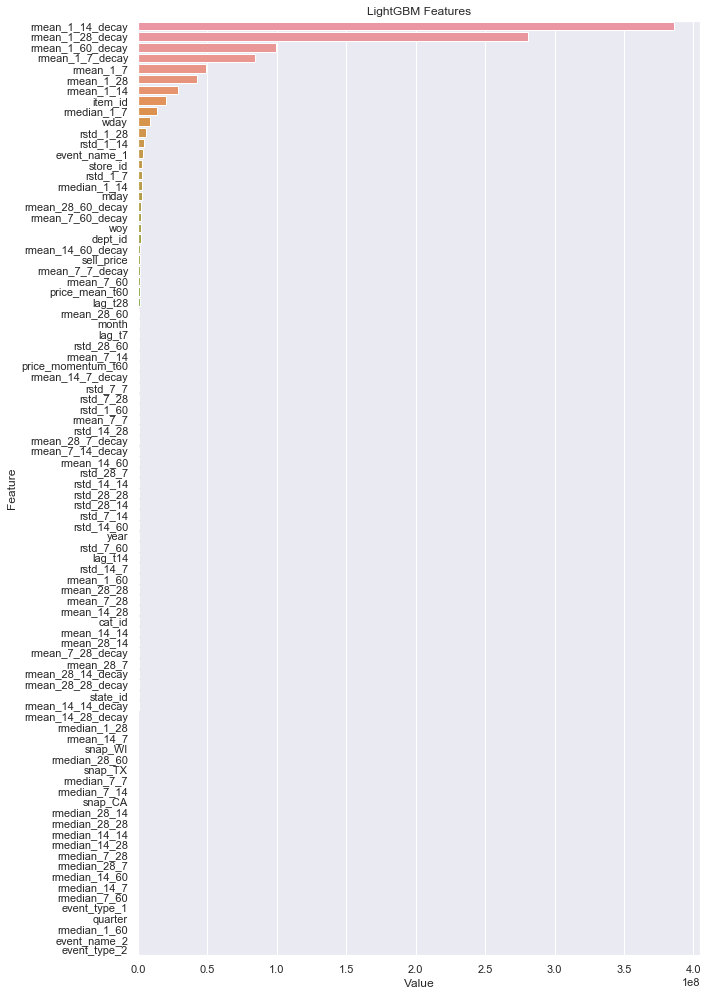

In [32]:
feature_importance = pd.DataFrame({"Value": m_lgb.feature_importance("gain"), "Feature": m_lgb.feature_name()}) \
                    .sort_values(by="Value", ascending=False)

# Change size of the plot, so we can see all features
fig_dims = (10, 14)
fig, ax = plt.subplots(figsize=fig_dims)

sns.barplot(x="Value", y="Feature", ax=ax, data=feature_importance)
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [33]:
# Detection of features with zero-importance
zero_features = list(feature_importance[feature_importance['Value'] == 0]['Feature'])
print('\nThere are {} features with 0.0 importance'.format(len(zero_features)))
print(zero_features)
feature_importance


There are 0 features with 0.0 importance
[]


,Value,Feature
38,3.857016e+08,rmean_1_14_decay
54,2.807613e+08,rmean_1_28_decay
70,9.953682e+07,rmean_1_60_decay
22,8.411428e+07,rmean_1_7_decay
19,4.934657e+07,rmean_1_7
51,4.258389e+07,rmean_1_28
35,2.909194e+07,rmean_1_14
0,2.060088e+07,item_id
20,1.401694e+07,rmedian_1_7
5,8.564204e+06,wday


In [61]:
%%time

for i in range(0, 28):
    day = FIRST_PRED_DAY + timedelta(days=i)
    print(i, day)
    tst = tdata[(tdata.date >= day - timedelta(days=MAX_LAGS)) & (tdata.date <= day)].copy()
    tst = create_lag_features_for_test(tst, day)
    tst = tst.loc[tst.date == day, train_cols]
    # Check that all features generated correctly
    if tst[tst.isna().any(axis=1)].shape[0] > 0:
        print('Some values in tst are nans:')
        print(tst[tst.isna().any(axis=1)])
    tdata.loc[tdata.date == day, "sales"] = m_lgb.predict(tst.values.astype(np.float32)) # 1.035*


0 2016-04-25 00:00:00
1 2016-04-26 00:00:00
2 2016-04-27 00:00:00
3 2016-04-28 00:00:00
4 2016-04-29 00:00:00
5 2016-04-30 00:00:00
6 2016-05-01 00:00:00
7 2016-05-02 00:00:00
8 2016-05-03 00:00:00
9 2016-05-04 00:00:00
10 2016-05-05 00:00:00
11 2016-05-06 00:00:00
12 2016-05-07 00:00:00
13 2016-05-08 00:00:00
14 2016-05-09 00:00:00
15 2016-05-10 00:00:00
16 2016-05-11 00:00:00
17 2016-05-12 00:00:00
18 2016-05-13 00:00:00
19 2016-05-14 00:00:00
20 2016-05-15 00:00:00
21 2016-05-16 00:00:00
22 2016-05-17 00:00:00
23 2016-05-18 00:00:00
24 2016-05-19 00:00:00
25 2016-05-20 00:00:00
26 2016-05-21 00:00:00
27 2016-05-22 00:00:00
CPU times: user 2h 30min 33s, sys: 8min 41s, total: 2h 39min 15s
Wall time: 2h 13min 20s


In [62]:
os.system('say "Prediction complete"')

0

In [63]:
tdata.loc[(tdata.date >= FIRST_PRED_DAY) & (tdata.sales > 2)].count()

id                    148403
item_id               148403
dept_id               148403
store_id              148403
cat_id                148403
state_id              148403
d                     148403
sales                 148403
date                  148403
wm_yr_wk              148403
weekday               148403
wday                  148403
month                 148403
year                  148403
event_name_1          148403
event_type_1          148403
event_name_2          148403
event_type_2          148403
snap_CA               148403
snap_TX               148403
snap_WI               148403
sell_price            148403
lag_t1                  4391
lag_t7                 34218
lag_t14                72907
lag_t28               148403
woy                   148403
quarter               148403
mday                  148403
price_mean_t60        148403
price_momentum_t60    148403
dtype: int64

In [64]:
%%time

tdata_sub = tdata.loc[tdata.date >= FIRST_PRED_DAY, ["id", "sales"]].copy()
tdata_sub.loc[tdata.date >= FIRST_PRED_DAY+ timedelta(days=h), "id"] = tdata_sub.loc[tdata.date >= FIRST_PRED_DAY+timedelta(days=h), 
                                                                     "id"].str.replace("validation$", "evaluation")
tdata_sub["F"] = [f"F{rank}" for rank in tdata_sub.groupby("id")["id"].cumcount()+1]
tdata_sub = tdata_sub.set_index(["id", "F" ]).unstack()["sales"][[f"F{i}" for i in range(1,29)]].reset_index()
tdata_sub.fillna(0., inplace = True)

# # kyakovlev magic trick
# for i in range(1,29):
#     tdata_sub['F'+str(i)] *= 1.02

tdata_sub.to_csv(f"{DATA_OUTPUT_DIR}/submission.csv",index=False)
tdata_sub.shape


CPU times: user 3.6 s, sys: 230 ms, total: 3.83 s
Wall time: 3.84 s


(60980, 29)

In [65]:
tst

,item_id,dept_id,store_id,cat_id,state_id,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_t7,lag_t14,lag_t28,rmean_1_7,rmedian_1_7,rstd_1_7,rmean_1_7_decay,rmean_7_7,rmedian_7_7,rstd_7_7,rmean_7_7_decay,rmean_14_7,rmedian_14_7,rstd_14_7,rmean_14_7_decay,rmean_28_7,rmedian_28_7,rstd_28_7,rmean_28_7_decay,rmean_1_14,rmedian_1_14,rstd_1_14,rmean_1_14_decay,rmean_7_14,rmedian_7_14,rstd_7_14,rmean_7_14_decay,rmean_14_14,rmedian_14_14,rstd_14_14,rmean_14_14_decay,rmean_28_14,rmedian_28_14,rstd_28_14,rmean_28_14_decay,rmean_1_28,rmedian_1_28,rstd_1_28,rmean_1_28_decay,rmean_7_28,rmedian_7_28,rstd_7_28,rmean_7_28_decay,rmean_14_28,rmedian_14_28,rstd_14_28,rmean_14_28_decay,rmean_28_28,rmedian_28_28,rstd_28_28,rmean_28_28_decay,rmean_1_60,rmedian_1_60,rstd_1_60,rmean_1_60_decay,rmean_7_60,rmedian_7_60,rstd_7_60,rmean_7_60_decay,rmean_14_60,rmedian_14_60,rstd_14_60,rmean_14_60_decay,rmean_28_60,rmedian_28_60,rstd_28_60,rmean_28_60_decay,price_mean_t60,price_momentum_t60,woy,quarter,mday
4481422,0,0,0,0,0,2,5,2016,0,0,0,0,0.0,0.0,0.0,8.382812,1.216797,0.997070,1.0,0.944824,0.859863,0.174194,1.175781,0.955078,0.895020,0.174438,1.215820,0.923340,0.916504,0.164062,1.001953,1.142578,1.0,0.899902,1.070312,0.934082,0.884766,0.150024,1.162109,0.939453,0.897461,0.163452,1.178711,0.924316,0.879883,0.150269,1.036133,0.928711,1.0,0.997070,1.075195,0.929199,0.884766,0.147461,1.093750,0.986816,0.922852,0.454102,1.093750,0.926270,0.945312,0.699707,1.045898,0.964355,1.0,1.137695,1.054688,0.950195,0.908203,0.797852,1.037109,1.043945,1.000000,0.887695,1.036133,1.032227,1.000000,0.950684,1.023438,1.033203,1.0,1.088867,1.022461,8.351562,1.003906,20,2,22
4481429,1,0,0,0,0,2,5,2016,0,0,0,0,0.0,0.0,0.0,3.970703,0.313965,0.213745,0.0,0.241455,0.218262,0.055695,0.319824,0.216431,0.177490,0.059601,0.311768,0.209106,0.199585,0.023254,0.204834,0.142822,0.0,0.377930,0.079407,0.221802,0.208252,0.051453,0.288574,0.212769,0.197876,0.043640,0.252441,0.208496,0.197876,0.041168,0.149902,0.071411,0.0,0.267334,0.086853,0.207520,0.197876,0.061554,0.178101,0.194092,0.185059,0.185181,0.158569,0.140015,0.162598,0.200195,0.126831,0.071411,0.0,0.262207,0.110474,0.196777,0.168213,0.290527,0.163208,0.173950,0.000000,0.295898,0.160522,0.182007,0.000000,0.335693,0.154297,0.199951,0.0,0.403320,0.150146,3.970703,1.000000,20,2,22
4481436,2,0,0,0,0,2,5,2016,0,0,0,0,0.0,0.0,0.0,2.970703,0.835938,0.723145,1.0,0.608887,0.546875,0.136230,0.763672,0.606934,0.530762,0.149292,0.836914,0.554199,0.478760,0.121643,0.736816,0.856934,1.0,0.377930,0.931641,0.599609,0.539062,0.125732,0.778320,0.580566,0.525391,0.133667,0.846680,0.559570,0.496338,0.137329,0.799805,1.000000,1.0,0.679199,0.875977,0.589355,0.525391,0.151001,0.735352,0.645996,0.539062,0.248169,0.748535,0.779785,0.728027,0.530762,0.721680,0.571289,0.0,0.689941,0.721680,0.558594,0.512207,0.498047,0.592285,0.518066,0.479736,0.524414,0.589844,0.480469,0.449707,0.548828,0.578613,0.516602,0.0,0.947754,0.572266,2.970703,1.000000,20,2,22
4481443,3,0,0,0,0,2,5,2016,0,0,0,0,0.0,0.0,0.0,4.640625,2.839844,2.419922,2.0,2.095703,1.867188,0.619629,3.111328,2.113281,1.898438,0.520508,2.839844,2.105469,1.873047,0.613770,2.449219,2.572266,2.0,2.369141,2.855469,2.074219,1.882812,0.517090,3.023438,2.109375,1.885742,0.546875,2.740234,2.037109,1.830078,0.667480,2.445312,2.072266,1.5,2.128906,2.470703,2.041016,1.860352,0.582031,2.505859,2.189453,1.863281,1.254883,2.365234,2.054688,1.830078,1.548828,2.250000,1.821289,1.0,1.886719,2.218750,2.101562,1.860352,1.602539,2.158203,2.156250,1.885742,1.647461,2.130859,2.025391,1.830078,1.721680,2.091797,1.916992,1.0,1.942383,2.068359,4.640625,1.000000,20,2,22
4481450,4,0,0,0,0,2,5,2016,0,0,0,0,0.0,0.0,0.0,2.880859,1.754883,1.263672,4.0,1.382812,1.196289,0.281250,1.807617,1.274414,1.152344,0.307129,1.758789,1.211914,1.150391,0.192749,1.323242,1.713867,2.0,1.253906,2.154297,1.293945,1.195312,0.261230,1.790039,1.243164,1.151367,0.248535,1.735352,1.175781,1.097656,0.